# Model Run English
Version 1.0

## Import Libs

In [1]:
import matplotlib.pyplot as plt
import os
import torch
from torch import optim
import numpy as np
from torch.utils.data import DataLoader

from paths import *
from model_config import *
from model_dataset import UngroundedSoundDataset
from model_model import *
from my_utils import get_timestamp
from misc_recorder import *
from misc_progress_bar import draw_progress_bar

## Localize Dirs

In [2]:
model_save_ = model_eng_save_dir

random_data_ = os.path.join(bsc_use_path, "phone_random.mfcc")
random_guide_train_ = os.path.join(bsc_use_path, "phone_random_train.csv")
random_guide_valid_ = os.path.join(bsc_use_path, "phone_random_validation.csv")
# random_guide_test_ = os.path.join(bsc_use_path, "phone_random.mfcc")

## Configure READ

In [3]:
READ = False

## Get Training Stamp

In [4]:
if READ: 
    ts = ""
else: 
    ts = str(get_timestamp())

train_name = "conf-1"
model_save_dir = os.path.join(model_save_, f"{train_name}-{ts}")
mk(model_save_dir)

stop_epoch = "149"
trainhist_name = "train.hst"
valhist_name = "val.hst"
valacc_name = "valacc.hst"

## Prepare Loss Recording

In [5]:
train_losses = ListRecorder(os.path.join(model_save_dir, trainhist_name))
valid_losses = ListRecorder(os.path.join(model_save_dir, valhist_name))

valid_accs = ListRecorder(os.path.join(model_save_dir, valacc_name))

In [6]:
train_ds = UngroundedSoundDataset(random_data_, random_guide_train_)
valid_ds = UngroundedSoundDataset(random_data_, random_guide_valid_)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, 
                          shuffle=True, 
                          num_workers=LOADER_WORKER)
train_num = len(train_loader.dataset)

valid_loader = DataLoader(valid_ds, batch_size=BATCH_SIZE, 
                          shuffle=False, 
                          num_workers=LOADER_WORKER)
valid_num = len(valid_loader.dataset)

In [7]:
train_num, valid_num

(1128637, 144059)

## Init Model

In [8]:
recon_loss = nn.MSELoss()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = ResAE(INPUT_DIM, INTER_DIM_1, INTER_DIM_2, INTER_DIM_3, LATENT_DIM, OUTPUT_DIM)
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-5)

In [9]:
model

ResAE(
  (encoder): Sequential(
    (0): LinPack(
      (lin): Linear(in_features=975, out_features=256, bias=True)
      (relu): ReLU()
      (batch_norm): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): ResBlock(
      (lin1): Linear(in_features=256, out_features=256, bias=True)
      (lin2): Linear(in_features=256, out_features=256, bias=True)
      (batch_norm): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (2): Linear(in_features=256, out_features=3, bias=True)
    (3): Sigmoid()
  )
  (decoder): Sequential(
    (0): LinPack(
      (lin): Linear(in_features=3, out_features=256, bias=True)
      (relu): ReLU()
      (batch_norm): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): ResBlock(
      (lin1): Linear(in_features=256, out_features=256, bias=True)
      (lin2): Linear(in_features=256, out_features=256, bias=True)
    

In [10]:
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
params

600392

## Load Model if READ

In [11]:
if READ: 
    valid_losses.read()
    train_losses.read()

    model_raw_name = f"{stop_epoch}"
    model_name = model_raw_name + ".pt"
    model_path = os.path.join(model_save_dir, model_name)
    state = torch.load(model_path)

    model.load_state_dict(state)
    model.to(device)

## Define Training

In [12]:
EPOCHS = 100
BASE = 0

In [13]:
def train(): 
    best_valid_loss = 1000000
    best_valid_loss_epoch = 0
    for epoch in range(BASE, BASE + EPOCHS):
        model.train()
        train_loss = 0.
        train_num = len(train_loader)    # train_loader
        for idx, (x, y) in enumerate(train_loader):
            optimizer.zero_grad()
            
            x = x.to(device)
            y = y.to(device)

            x_hat = model(x)
            loss = recon_loss(x_hat, y)
            train_loss += loss.item()

            loss.backward()
            
            # torch.nn.utils.clip_grad_norm_(model.parameters(), clip_value)
            # 这个函数计算的是全局梯度范数
            # torch.nn.utils.clip_grad_norm(parameters=model.parameters(), max_norm=5, norm_type=2)
            # torch.nn.utils.clip_grad_norm_(parameters=model.parameters(), max_norm=5, norm_type=2)
            # parameters: an iterable of Variables that will have gradients normalized
            # max_norm: max norm of the gradients(阈值设定)
            # norm_type: type of the used p-norm. Can be'inf'for infinity norm(定义范数类型)

            optimizer.step()

            # draw_progress_bar(idx, train_num)

        train_losses.append(train_loss / train_num)

        last_model_name = f"{epoch}.pt"
        torch.save(model.state_dict(), os.path.join(model_save_dir, last_model_name))

        model.eval()
        valid_loss = 0.
        valid_num = len(valid_loader)
        for idx, (x, y) in enumerate(valid_loader):
            x = x.to(device)
            y = y.to(device)

            x_hat = model(x)
            loss = recon_loss(x_hat, y)
            valid_loss += loss.item()

            # draw_progress_bar(idx, valid_num)

        avg_valid_loss = valid_loss / valid_num
        valid_losses.append(avg_valid_loss)
        if avg_valid_loss < best_valid_loss: 
            best_valid_loss = avg_valid_loss
            best_valid_loss_epoch = epoch

        draw_learning_curve(losses=(train_losses.get(), valid_losses.get()), 
                            others=best_valid_loss_epoch, 
                            epoch=str(epoch))
        train_losses.save()
        valid_losses.save()

    return best_valid_loss_epoch

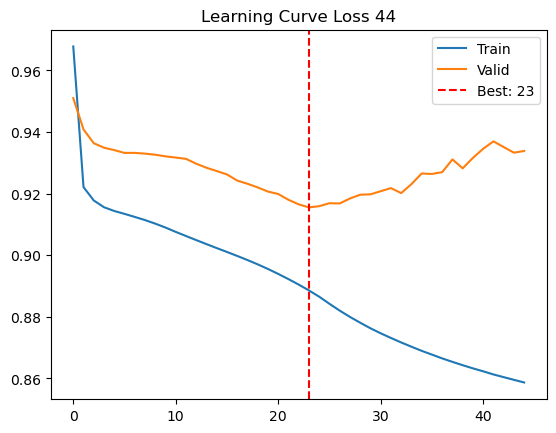

In [14]:
if __name__ == "__main__": 
    best_valid_loss_epoch = train()